In [ ]:
using CSV, DataFrames, MarketData, Plots, Statistics, TimeSeries

c1 = theme_palette(:auto).colors.colors[1]
c2 = theme_palette(:auto).colors.colors[2]
c3 = theme_palette(:auto).colors.colors[3]

In [ ]:
function load(ticker)
    df = CSV.read("data/" *ticker* ".csv", DataFrame)
    day = SubString.(df.Date, 1, 10)
    d = Date.(day)
    select!(df, Not(:Date))
    df[:, :Date] = d
    df[:, :Day] = day
    df
end

function plot_Rclose(ticker::String)
    df = load(ticker)
    plot(df.Date, df.Close, label=ticker * " Close", ylabel="EOD Price")
    plot!(df.Date, df.RClose, color=c2, label="Add back dividend")
end

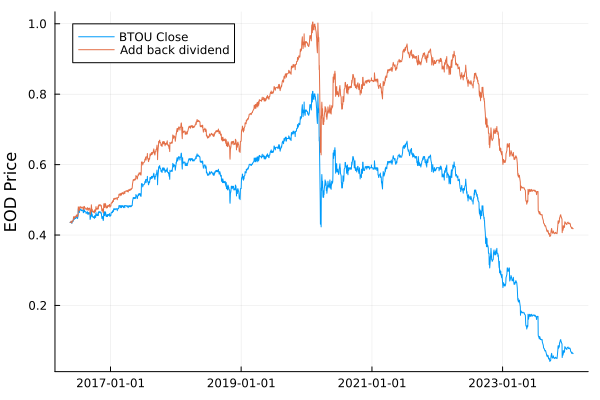

In [18]:
plot_Rclose("BTOU")

In [13]:
function fetch_with_rclose(ticker::String, year::Int, duration::Int=1)
    df = load(ticker)
    i = findfirst(x -> x > Date(string(year) * "-01-01"), df.Date)
    prev = df[i, :]
    df = df[string(year)*"-01-01".<df.Day.<string(year + duration)*"-01-01", :]
    df[:, :RClose] = copy(df.Close)

    delta = 0
    last_dividend = 1
    count = size(df, 1)

    for i in range(1, count)
        row = df[i, :]

        if row.Dividends > 0
            gap = row.Dividends / (i - last_dividend)
            for j in range(last_dividend + 1, i)
                df[j, :RClose] = df[j, :].RClose + gap * (j - last_dividend) + delta
            end
            delta += row.Dividends
            last_dividend = i
        end
    end

    if delta > 0
        for i in range(last_dividend + 1, count)
            df[i, :RClose] = df[i, :].RClose + delta
        end
    end
    return df, prev
end

function plot_rclose_year(ticker::String, year::Int, duration::Int=1)
    df, _ = fetch_with_rclose(ticker, year, duration)

    plot(Date.(SubString.(df.Date, 1, 10)), df.Close, label=ticker * " Close", ylabel="EOD Price")
    plot!(Date.(SubString.(df.Date, 1, 10)), df.RClose, label="Add back dividend")
end

plot_rclose_year (generic function with 2 methods)

In [ ]:
sti, sti_prev = fetch_with_rclose("ES3", 2019, 5)
d05, d05_prev = fetch_with_rclose("D05", 2019, 5)

In [ ]:
# cov(es3_2.RClose_last, d05_2.RClose_last) - cov(es3_2.RClose_last, d05_2.Close_last)
# cov(es3_2.Close_last, d05_2.Close_last) / var(es3_2.Close_last)
function get_return(df, prev)
    df2 = combine(groupby(transform(df, :Date => x -> yearmonth.(x)), :Date_function), :Close => last, :RClose => last)
    df2[:, :Return] = copy(df2.Close_last)
    df2[:, :RReturn] = copy(df2.Close_last)

    df2[1, :Return] = (df2[1, :Close_last] - prev.Close) / prev.Close
    df2[1, :RReturn] = df2[1, :Return]

    for i in range(2, size(df2, 1))
        df2[i, :Return] = (df2[i, :Close_last] - df2[i-1, :Close_last]) / df2[i-1, :Close_last]
        df2[i, :RReturn] = (df2[i, :RClose_last] - df2[i-1, :RClose_last]) / df2[i-1, :RClose_last]
    end

    df2
end

sti_2 = get_return(sti, sti_prev)
d05_2 = get_return(d05, d05_prev)

In [34]:
println(cov(sti_2.Return, d05_2.Return) / var(sti_2.Return))
println(cov(sti_2.RReturn, d05_2.RReturn) / var(sti_2.RReturn))

1.2761838576946536
1.2049904745576647


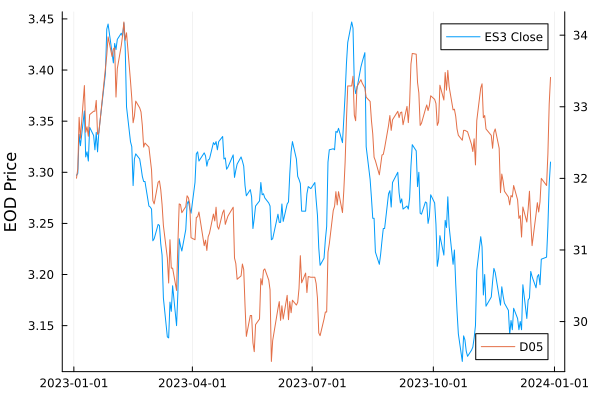

In [91]:
# plot_rclose_year("ES3", 2023)
plot(Date.(SubString.(es3.Date, 1, 10)), es3.Close, label="ES3 Close", ylabel="EOD Price")
plot!(twinx(), Date.(SubString.(d05.Date, 1, 10)), d05.Close, label="D05", color=c2)

# STI Estimation using ES3

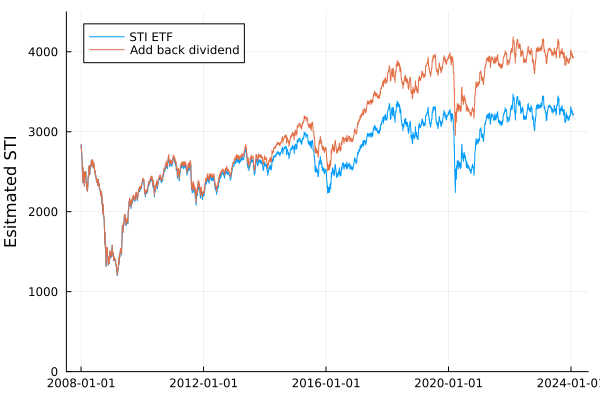

In [35]:
es3 = load("ES3")
plot(es3.Date, es3.Close .* 1000, label="STI ETF", ylim=(0, 4500), ylabel="Esitmated STI")
plot!(es3.Date, es3.RClose .* 1000, color=c2, label="Add back dividend")
# savefig("dividend/sti_estimate.png")

# Dividends

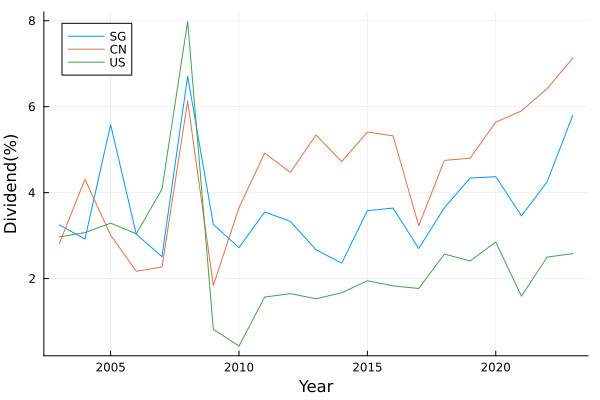

In [36]:
data = CSV.read("dividend/data.txt", DataFrame)
plot(data.Year, data.SG, label="SG", ylabel="Dividend(%)", xlabel="Year")
plot!(data.Year, data.China, label="CN")
plot!(data.Year, data.US, label="US")
# scatter!(data.Year, data.Average, label="Average", smooth=true)
# savefig("dividend/sg_cn_us.png")

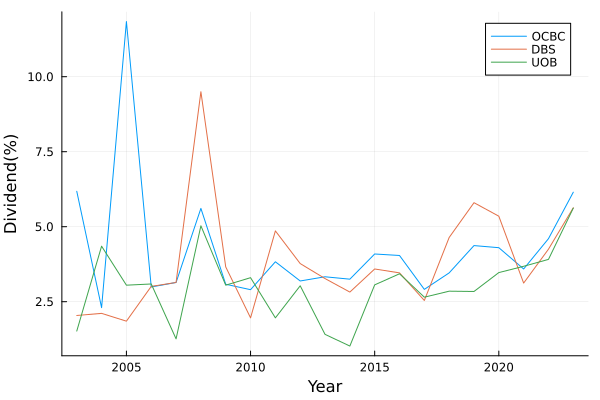

In [39]:
localbanks = CSV.read("dividend/local.csv", DataFrame)
banks = first(localbanks,21)
plot(banks.year, banks.ocbc, label="OCBC", ylabel="Dividend(%)", xlabel="Year")
plot!(banks.year, banks.dbs, label="DBS")
plot!(banks.year, banks.uob, label="UOB")
# savefig("dividend/local.png")

# REITs

In [ ]:
reits_tickers = ["8U7U", "A17U", "AJBU", "AU8U", "AW9U", "BMGU", "BTOU", "BUOU", "BWCU", "C2PU", "C38U", "CMOU", "CRPU", "CWBU", "CWCU", "D5IU", "DCRU", "DHLU", "HMN", "J69U", "J85", "J91U", "JYEU", "K71U", "M1GU", "M44U", "ME8U", "MXNU", "N2IU", "O5RU", "ODBU", "OXMU", "P40U", "Q5T", "SK6U", "T82U", "TS0U", "UD1U", "XZL"]
function cal_reits(ticker::String)
    df3 = CSV.read("data/" * ticker * ".csv", DataFrame)
    close = last(df3[df3.Date.<"2024-01-01", :]).Close
    d = sum(df3["2023-01-01".<df3.Date.<"2024-01-01", :].Dividends)
    return (Ticker=ticker, Close=close, Dividend=d)
end

reit_returns = DataFrame(DataFrame([[], [], []], ["Ticker", "Close", "Dividend"]))
for ticker in reits_tickers
    row = cal_reits(ticker)
    push!(reit_returns, row)
end

reits = reit_returns[reit_returns.Dividend.>0, :]
reits[!, :Yield] = reits.Dividend ./ reits.Close
scatter(reits.Close, reits.Yield, label="Reits dividend yield 2023")
# CSV.write("REITs analysis/reit_returns.csv", reits)